# Lotka-Volterra Simulations

This notebook contains inference results for the Lotka-Volterra model using simulated data. 

Using both the bootstrap and MVN filters, we plot the posteriors for each parameter with the following resolution numbers in high and low noise settings: 

- n_res = 1
- n_res = 2
- n_res = 8
- n_res = 16

### Notes

- The full Fisher information matrix isn't always reliable, it depends on the approximation of the log-likelihood. Sometimes for a very small number of particles we can get the full Fisher information matrix, sometimes for a large number of particles the FI matrix isn't positive definite.  This is for resolution size of 1 and low noise. 
- It seems like the MVN filter works better for the high noise setting and the bootstrap filter works better for the low noise setting?

In [74]:
import time
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as random
from jax import lax

import pfjax as pf
import pfjax.sde

import warnings
warnings.filterwarnings('ignore')

In [75]:
def update_params(params, subkey, opt_state, grad_fun=None, n_particles=100, 
                  y_meas=None, model=None, learning_rate=0.01, mask=None,
                  optimizer=None):
    '''
    Args:
        params: A jnp.array that represents the values of the parameters before the gradient update.
        subkey: The subkey for the current loop iteration.
        opt_state: The optimizer state of the parameters.
        grad_fun: The function with which to take the gradients with respect to.
        n_particles: The number of particles for the particle filter.
        y_meas: The observed data `y_meas`
        model: The model class which has the predefined methods to run the forward pass.
        learning_rate: The learning rate for the stochastic optimization method.
        mask: A mask (0 or 1 vector) which represents the parameters that we wish to update in an iteration.
        optimizer: The choice of stochastic optimizer (e.g. Adam/Adagrad)
    
    Returns:
        params: The updated parameters at the end of the stochastic optimization step.
    '''
    params_update = jax.grad(grad_fun, argnums=0)(
        params, subkey, n_particles, y_meas, model)
    params_update = jnp.where(mask, params_update, 0)
    updates, opt_state = optimizer.update(params_update, opt_state)
    return optax.apply_updates(params, updates) 


def simple_grad_descent (model, theta, grad_fun, y_meas, n_particles=100, 
                         n_iter=10, learning_rate=0.01, key=1, mask=None):
    """ Deterministic optimization """
    optimizer = optax.adam(learning_rate) 
    opt_state = optimizer.init(theta)
    partial_update_params = partial(update_params, n_particles=n_particles, y_meas=y_meas,
                                    model=model, learning_rate=learning_rate, mask=mask, 
                                    grad_fun=grad_fun, optimizer=optimizer)
    update_fn = jax.jit(partial_update_params, donate_argnums=(0,))
    for i in range(n_iter):
        # get value of loss function to make sure we are minimizing 
        theta = update_fn(theta, subkey, opt_state)
    return theta


def stoch_opt(model, theta, grad_fun, y_meas, n_particles=100, 
              n_iter=10, learning_rate=0.01, key=1, mask=None):
    """
    Args:
        model: The model class for which all of the functions are defined.
        theta: A jnp.array that represents the initial values of the parameters.
        grad_fun: The function which we would like to take the gradient with respect to.
        y_meas: The measurements of the observations required for the particle filter.
        n_particles: The number of particles to use in the particle filter.
        n_iter: The number of n_iter to run the gradient descent for.
        learning_rate: The learning rate for the gradient descent algorithm.
        key: The key required for the prng.
        mask: The mask over which dimensions we would like to perform the optimization.
    
    Returns:
        theta: The final value of the parameters.
    """
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(theta)
    # Partially evaluate the function with respect to all of the parameters that do not change over time.
    partial_update_params = partial(update_params, n_particles=n_particles, y_meas=y_meas,
                                    model=model, learning_rate=learning_rate, mask=mask, grad_fun=grad_fun, 
                                    optimizer=optimizer)
    # JIT the update step.
    update_fn = jax.jit(partial_update_params, donate_argnums=(0,))
    # Every iteration, the keys must be split to obtain several subkeys for which we have to take the update step.
    keys = random.split(key, n_iter)
#     print(len(keys))
    for subkey in keys:
        theta = update_fn(theta, subkey, opt_state)
    return theta 

In [76]:
# log-likelihood for Lotvol model with MVN resamplings
@jax.jit
def lotvol_pf_mvn_loglik(theta):
    temp = pf.particle_filter(theta=theta, model=lotvol_model, 
                           y_meas=y_meas, 
                           n_particles=n_particles, key=key,
                           particle_sampler = pf.particle_resample_mvn)
    return pf.particle_loglik(temp['logw'])

# log-likelihood for Lotvol model with Multinomial resampling
@jax.jit
def lotvol_pf_loglik(theta):
    temp = pf.particle_filter(theta=theta, 
                           model=lotvol_model, y_meas=y_meas,
                           n_particles=n_particles, key=key)
    return pf.particle_loglik(temp['logw'])

# Low Noise Setting


In [77]:
# parameter values
alpha = 1.0
beta = 1.0
gamma = 4.0
delta = 1.0
sigma_h = 0.1
sigma_l = 0.1
tau_h = 0.1 
tau_l = 0.1 

theta = np.array([alpha, beta, gamma, delta, sigma_h, sigma_l, tau_h, tau_l])
theta_names = ["alpha", "beta", "gamma", "delta",
               "sigma_h", "sigma_l", "tau_h", "tau_l"]
theta_lims = np.array(list(zip(theta - (theta/1.5), theta + (theta/1.5))))

dt = 0.1
n_res = 1 # 1, 2, 4, 8, 16
n_obs = 100
lotvol_model = pf.LotVolModel(dt, n_res) 

key = random.PRNGKey(0)
key, subkey = random.split(key)

x_init = jnp.block([[jnp.zeros((n_res-1, 2))],
                    [jnp.log(jnp.array([5., 3.]))]])

y_meas, x_state = pf.simulate(model = lotvol_model, 
                              n_obs = n_obs, 
                              x_init = x_init, 
                              theta = theta, 
                              key = subkey)
y_meas_abs = jnp.abs(y_meas)

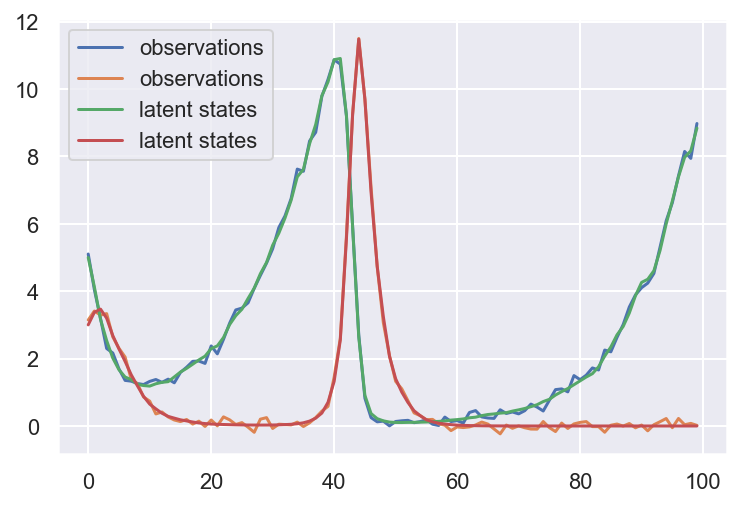

In [78]:
plt.plot(y_meas, label = "observations");
# plt.plot(x_state.reshape(n_obs, n_res*2), label = "latent states")
plt.plot(jnp.exp(x_state.squeeze()), label = "latent states")
plt.legend();

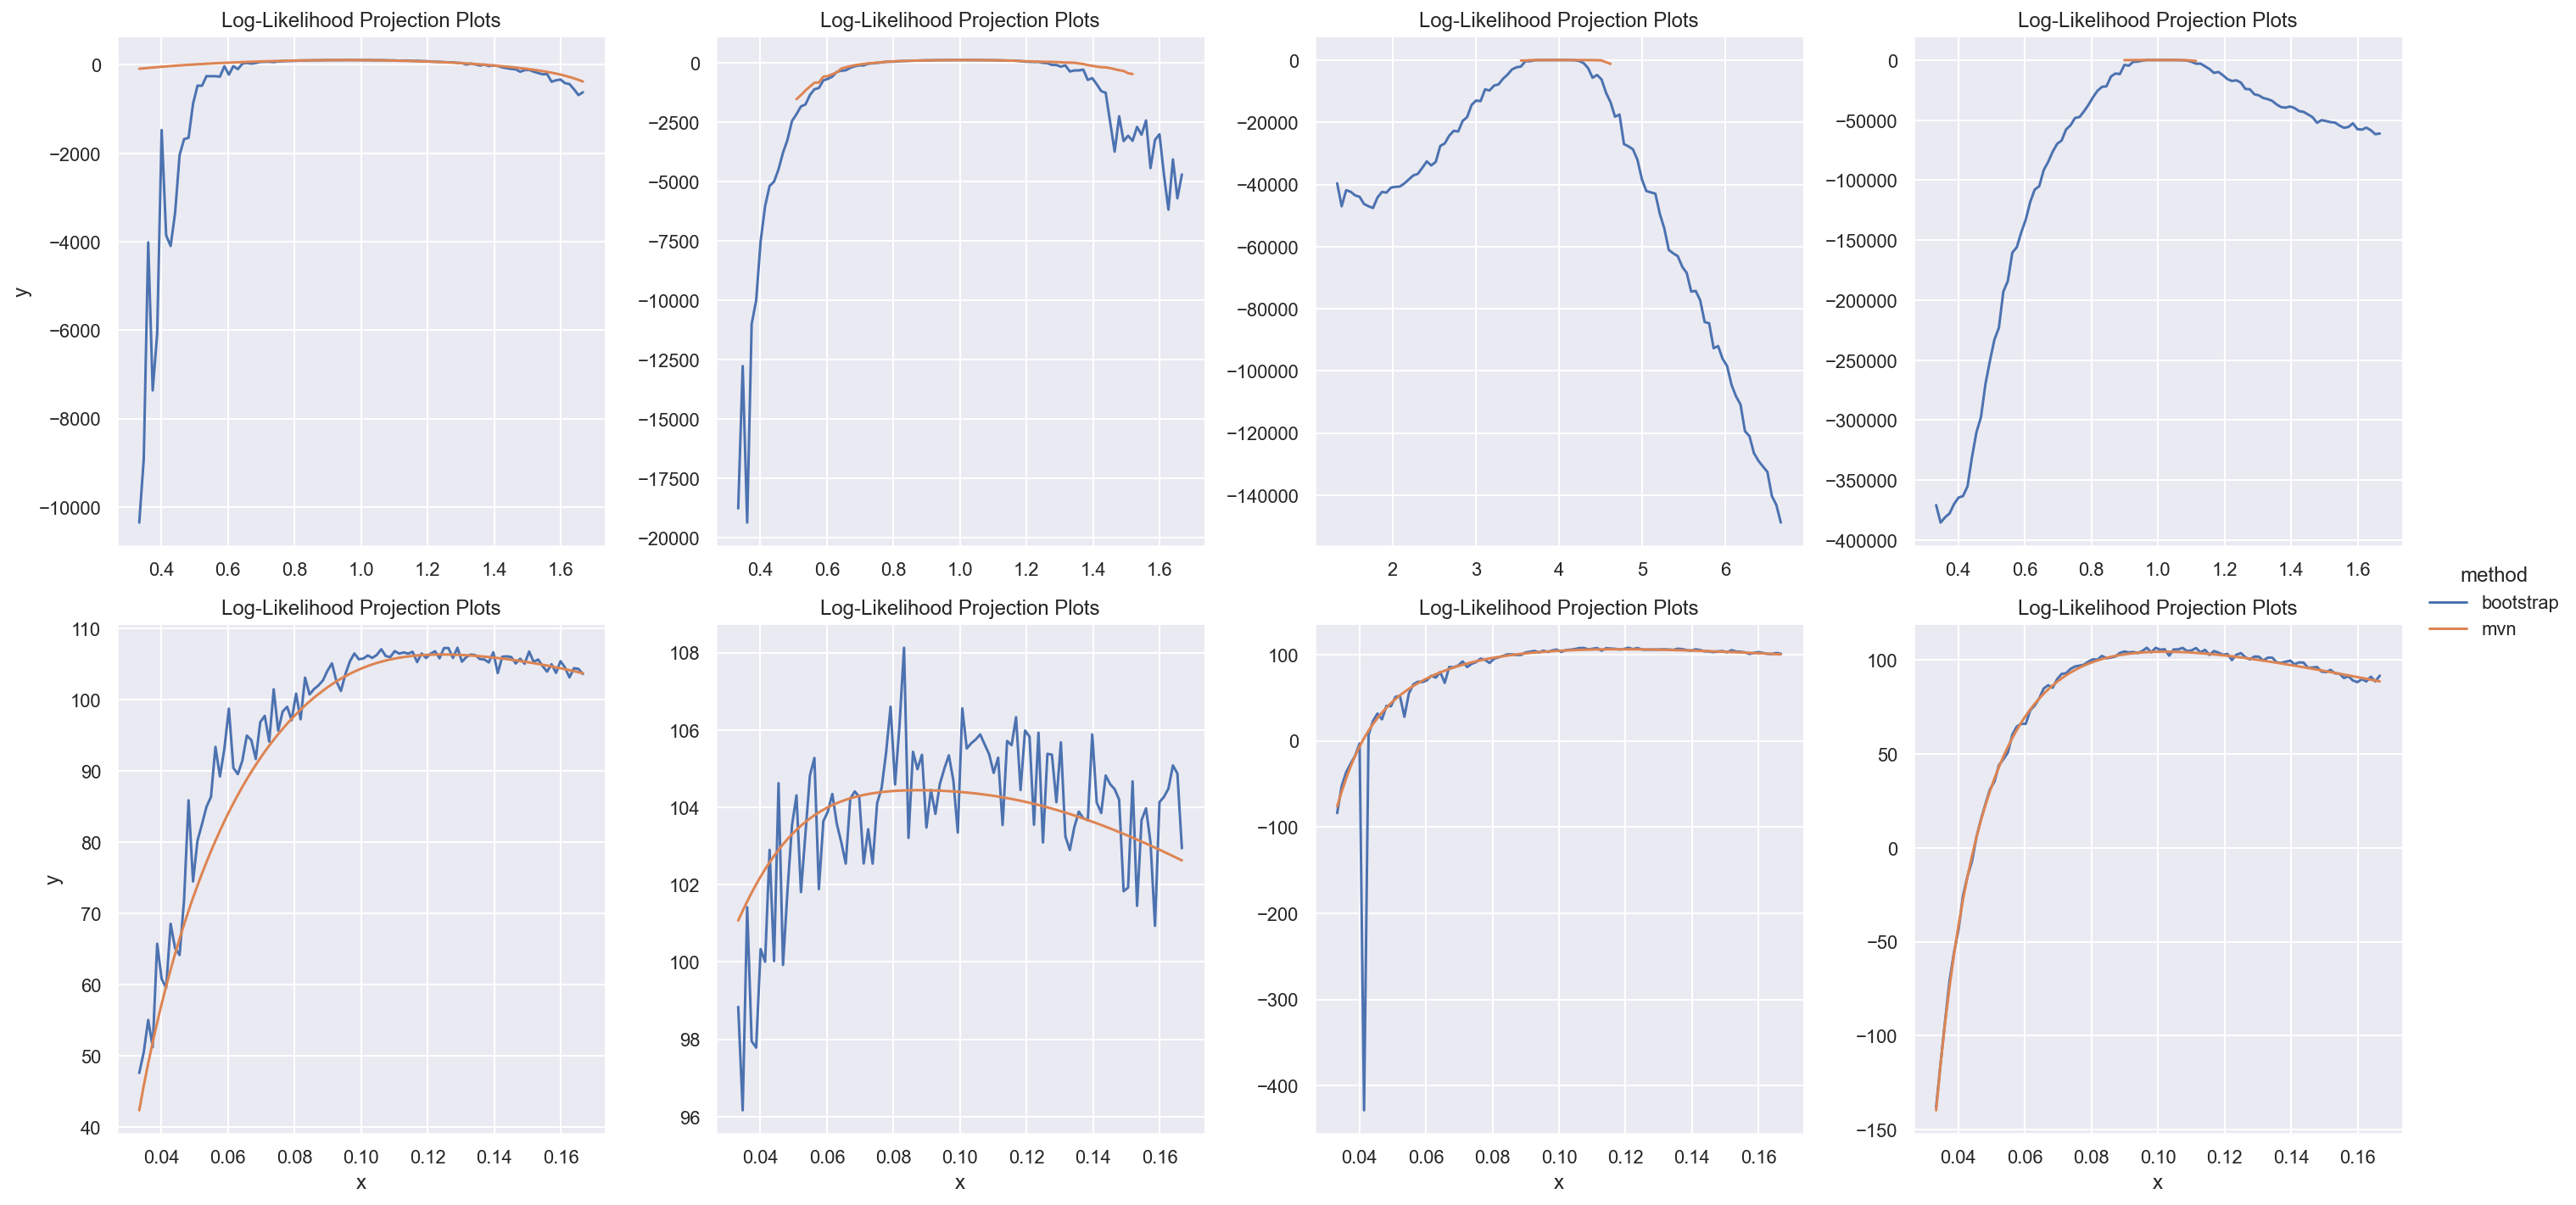

In [79]:
n_particles = 500

plot_mvn = pf.proj_data(fun = lambda x: lotvol_pf_mvn_loglik(x), 
                        theta = theta, theta_lims = theta_lims, 
                        theta_names = theta_names)

plot_bootstrap = pf.proj_data(fun = lambda x: lotvol_pf_loglik(x),
                           theta = theta, 
                           theta_lims = theta_lims, 
                           theta_names = theta_names)

plot_mvn["method"] = "mvn"
plot_bootstrap["method"] = "bootstrap"
df = pd.concat([plot_bootstrap, plot_mvn]).reset_index(drop=True)

sns.relplot(
    data=df, 
    kind="line",
    hue = "method",
    x="x", y="y", 
    col="theta",
    col_wrap=4,
    facet_kws=dict(sharex=False, sharey=False)
).set(title="Log-Likelihood Projection Plots");

## Multivariate Gaussian Resampling

In [25]:
init_params = jnp.array([1.,0.9, 3.8, 1., 0.1, 0.1, 0.1, 0.1])
print("True params: ", theta)

mvn_params = simple_grad_descent(
    key = key,
    model = lotvol_model,
    grad_fun = pf.particle_neg_loglik_mvn,
    y_meas = y_meas,
    theta = init_params,
    learning_rate = 1e-2,
    n_iter = 50,
    n_particles = 100,
    mask=np.ones(len(init_params))
)
mvn_params

True params:  [1.  1.  4.  1.  0.1 0.1 0.1 0.1]


DeviceArray([0.92000055, 0.9799994 , 3.8999999 , 1.        , 0.13999973,
             0.10000001, 0.11999987, 0.1       ], dtype=float32)

In [28]:
theta_lims

array([[0.33333333, 1.66666667],
       [0.33333333, 1.66666667],
       [1.33333333, 6.66666667],
       [0.33333333, 1.66666667],
       [0.03333333, 0.16666667],
       [0.03333333, 0.16666667],
       [0.03333333, 0.16666667],
       [0.03333333, 0.16666667]])

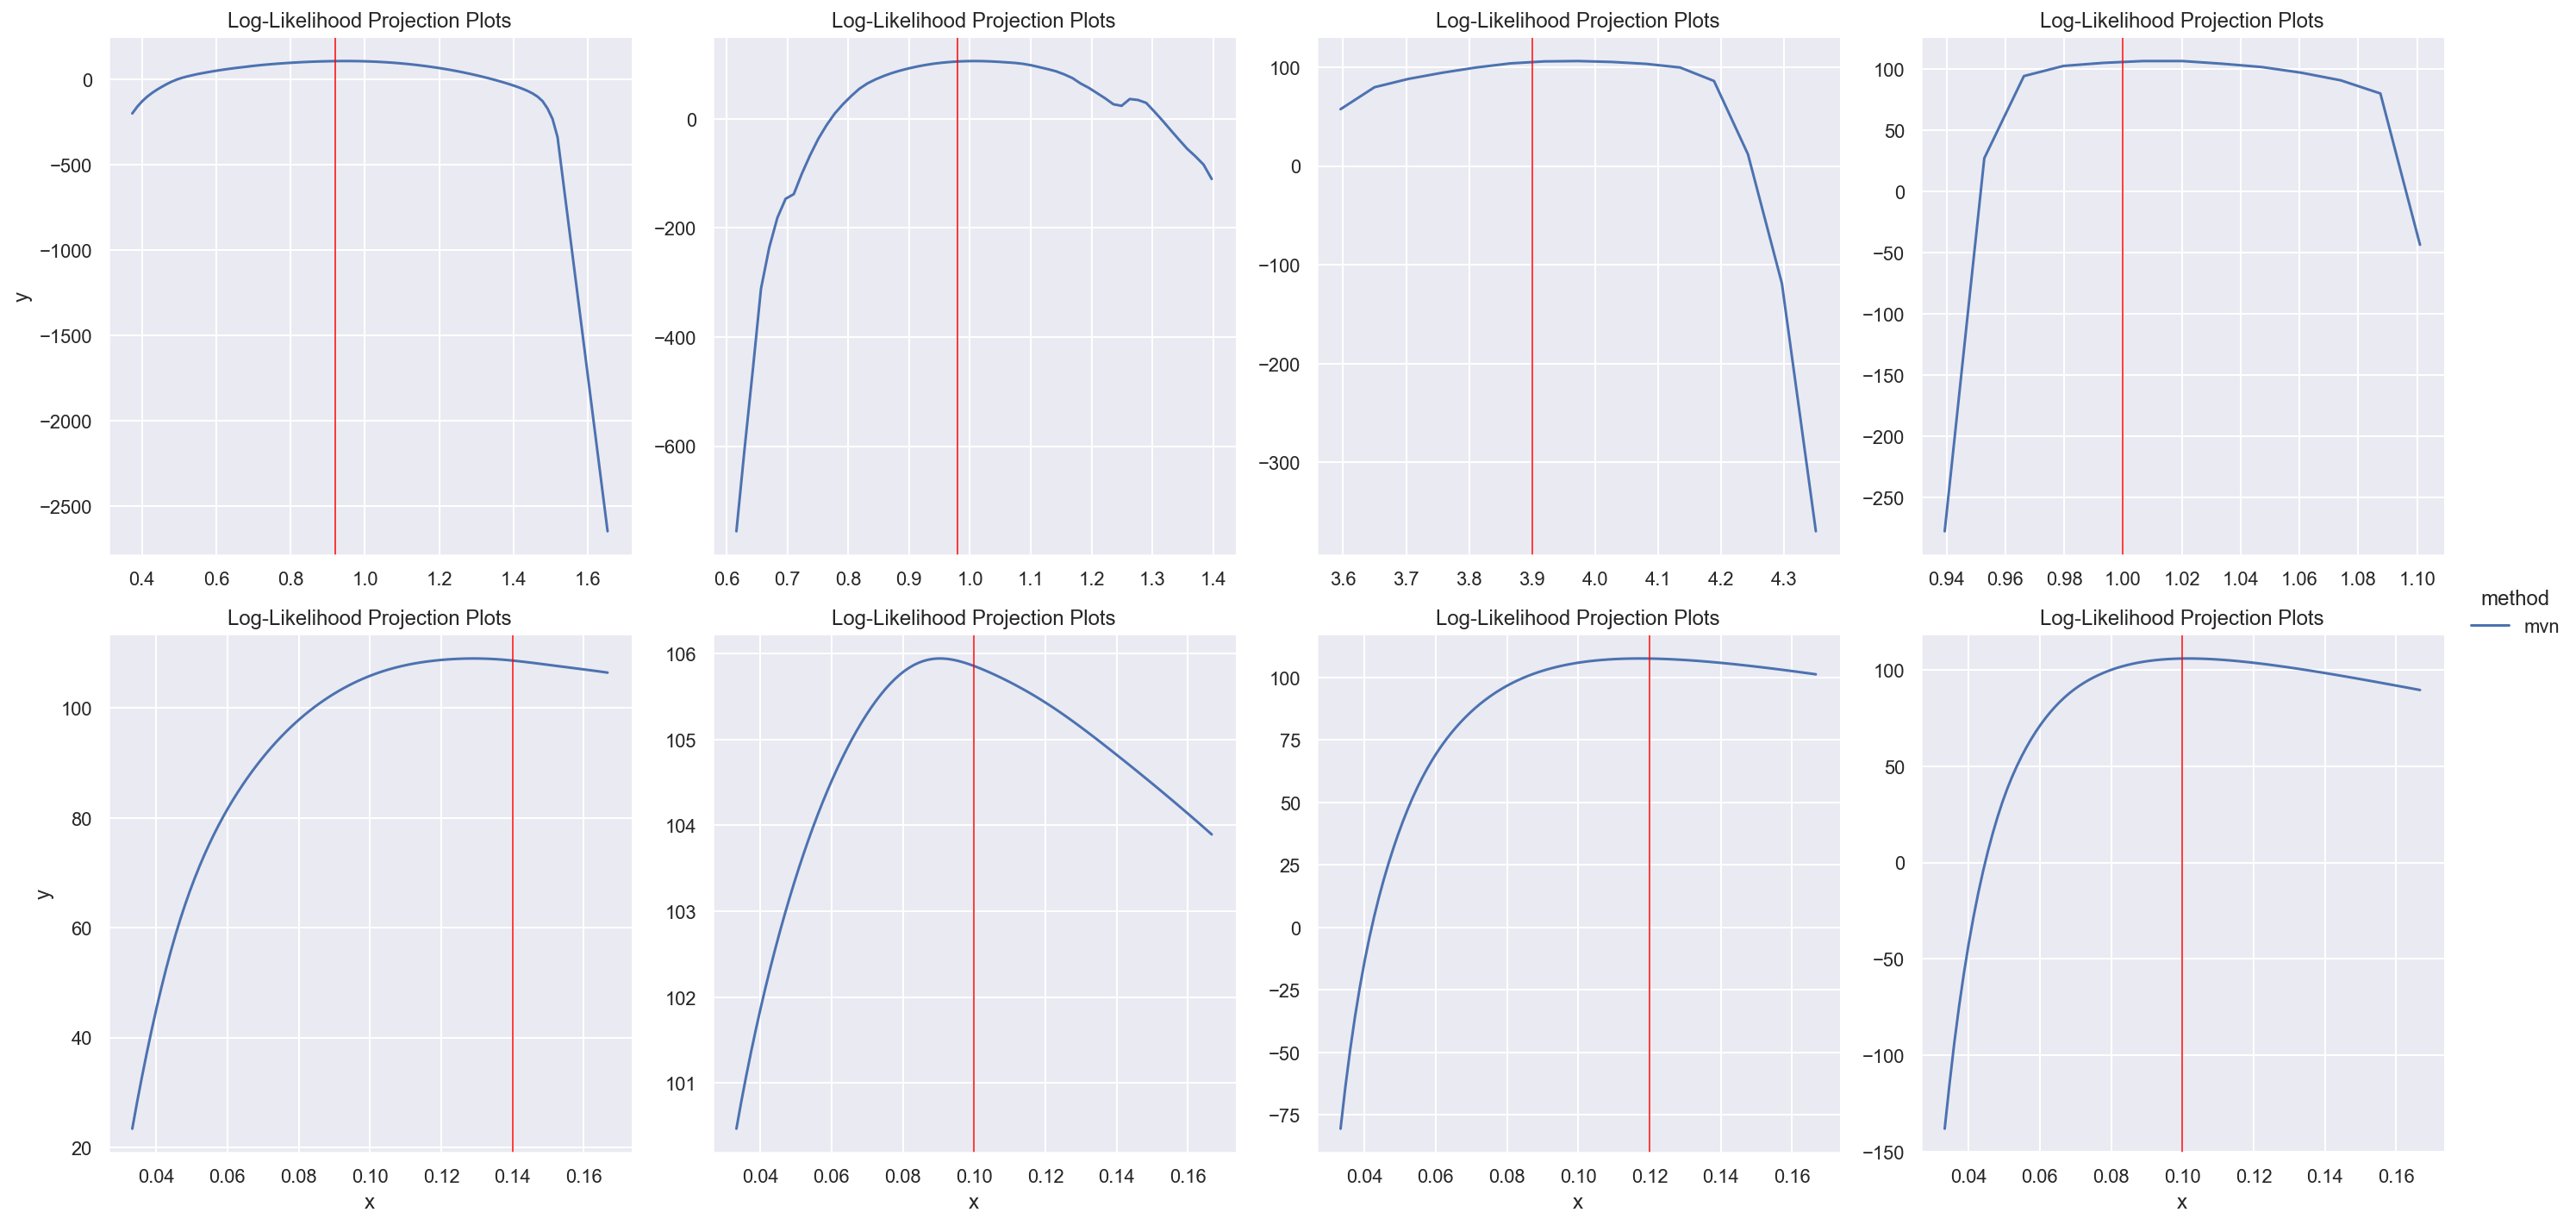

In [27]:
plot_mvn = pf.proj_data(fun = lambda x: lotvol_pf_mvn_loglik(x), 
                    theta = theta, theta_lims = theta_lims, 
                    theta_names = theta_names)

plot_mvn["method"] = "mvn"

grid = sns.relplot(
    data=plot_mvn, 
    kind="line",
    hue = "method",
    x="x", y="y", 
    col="theta",
    col_wrap=4,
    facet_kws=dict(sharex=False, sharey=False)
).set(title="Log-Likelihood Projection Plots")

for ind, _ax in enumerate(grid.axes.flat):
    _ax.axvline(mvn_params[ind], color='red', lw = 0.75);

#### Question: Why does MVN resampling break down when $\theta$ is far from $\theta_{\text{true}}$? 

I suspect this is because the weights get very small and the corresponding mean and covariance matrix of the MVN approximation get very close to zero. However this won't happen in Multinomial resampling since the resampler can only choose from a set of particles.

By looking at the particle filter output for 2 different settings of $\theta$, this can be confirmed. When $\theta$ is far away from the true value, the log-weights get smaller and smaller. It is almost like a self-fullfilling profecy - low weights mean low variance, which mean no exploration, which leads to even lower weights. 

On the other hand, when the parameters are close to the true values, there is a good balance between exploration and exploitation in the MVN approximation. The covariance matrix does not have extremely small values.

Will we have this problem with all density estimators? It seems like we would. 

#### Solution

One potential solution can be to disregard the weights if they get too small. We can sample from N(0, 1) if the average/median weight is below some threshold. Good luck doing this in JAX. 

In [52]:
temp = pf.particle_filter(
    theta=jnp.array([1. , 1. , 4. , 1. , 0.1, 0.1, 0.1, 0.1]), 
    model=lotvol_model, 
    y_meas=y_meas, 
    n_particles=n_particles, key=key,
    particle_sampler = pf.particle_resample_mvn)

In [73]:
# i = 0
print(temp["logw"][i, :10])
print(temp["x_particles_cov"][i, :, :])
print(temp["x_particles_mu"][i, :])
i += 1

[2.384041  2.6973476 2.7119808 2.6970103 2.1357346 2.5085769 2.687667
 2.4373906 2.5135727 1.3912743]
[[ 1.4712476e-03 -4.9192095e-05]
 [-4.9192091e-05  6.0566287e-03]]
[ 0.4492062 -1.7505978]


In [40]:
# check that we have minimized the negative log-lik: Hessian should be positive definite: 
hessian_fn = jax.jacfwd(jax.jacrev(pf.particle_neg_loglik_mvn))
hess = hessian_fn(
    mvn_params,
    key,
    n_particles=100,
    y_meas=y_meas,
    model=lotvol_model)
print("Is positive definite?: ", jnp.all(jnp.linalg.eigvals(hess) >= 0))

Is positive definite?:  True


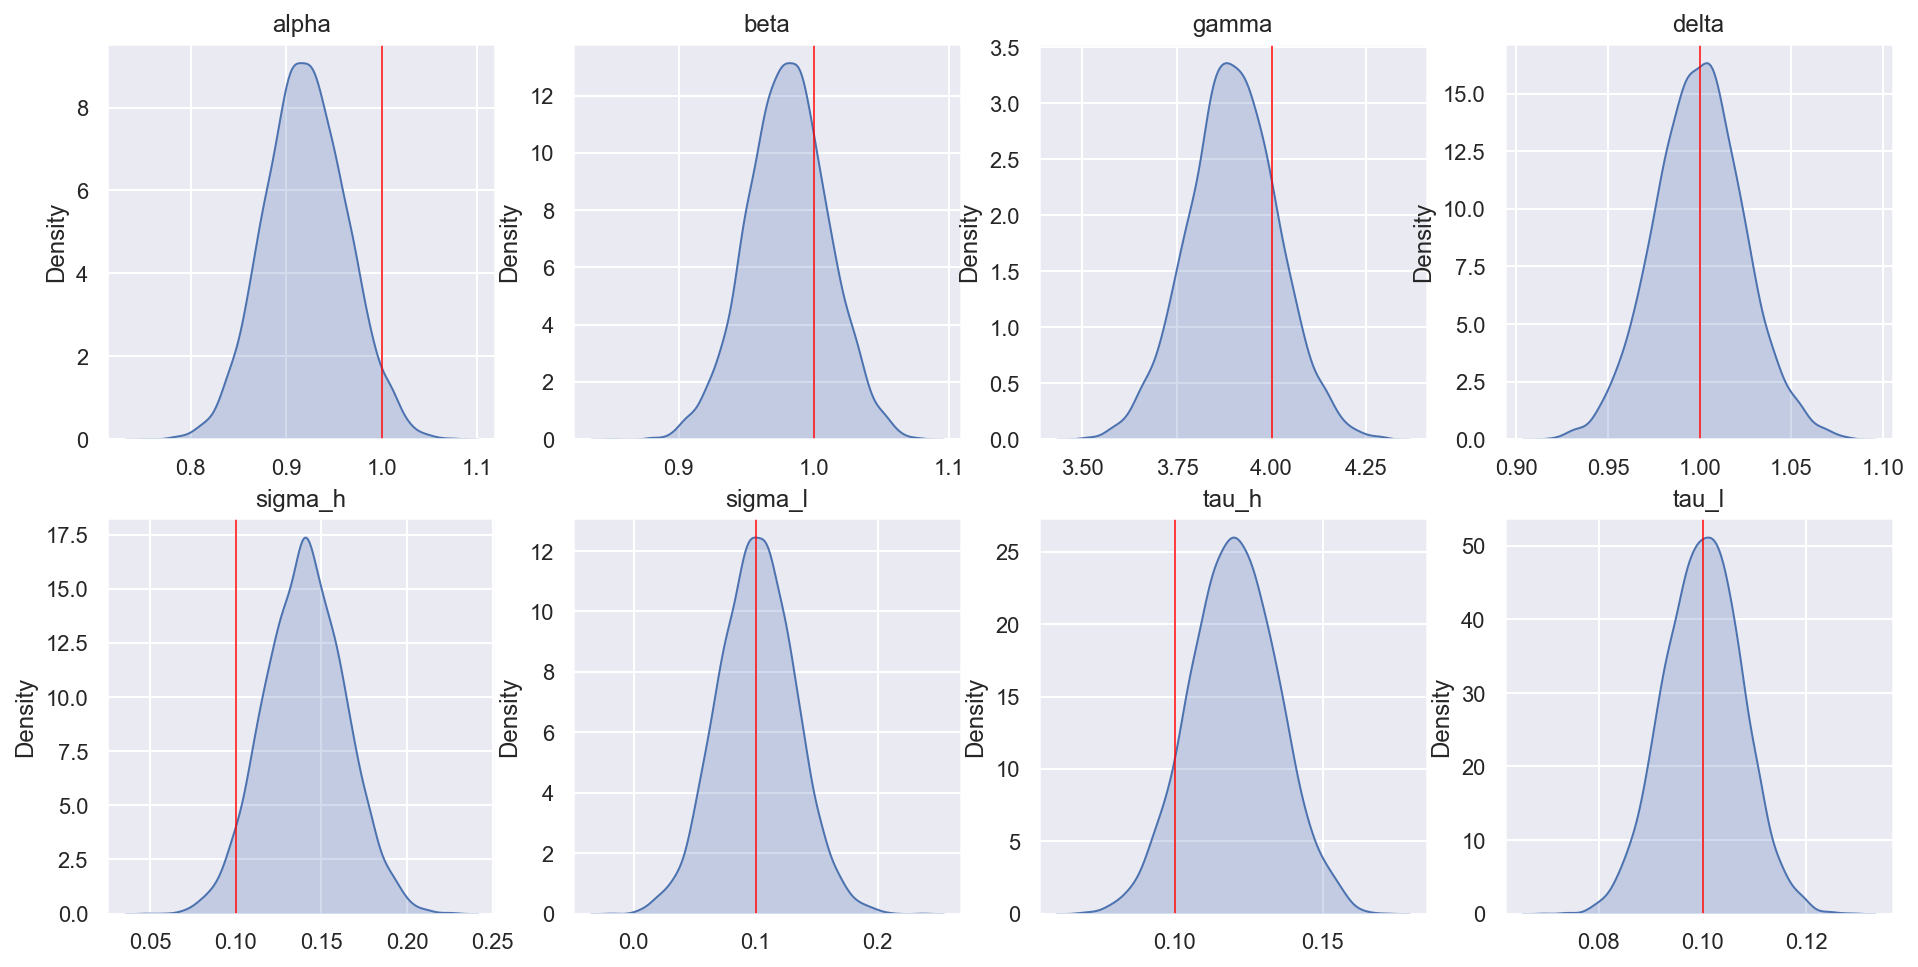

In [16]:
var = jnp.linalg.inv(hess)

mle_samples = random.multivariate_normal(key=key, mean=mvn_params, cov=var, shape=(5_000, ))

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
for ind, _ax in enumerate(ax.flatten()):
    sns.kdeplot(mle_samples[:, ind], ax = _ax, shade = True).set_title(theta_names[ind])
    _ax.axvline(theta[ind], color='red', lw = 0.75)

plt.show();

## Multinomial Resampling

In [87]:
# Fix parameters and run both filters with these: 
n_particles = 250
n_iter = 500
learning_rate = 1e-3

init_params = jnp.array([1.,0.9, 3.8, 1., 0.1, 0.1, 0.1, 0.1])
print("True params:    ", theta)
print("Initial params: ", init_params)

True params:     [1.  1.  4.  1.  0.1 0.1 0.1 0.1]
Initial params:  [1.  0.9 3.8 1.  0.1 0.1 0.1 0.1]


In [88]:
multinom_params = stoch_opt(
    key = key,
    model = lotvol_model,
    grad_fun = pf.particle_neg_loglik,
    y_meas = y_meas,
    theta = init_params,
    learning_rate = learning_rate,
    n_iter = n_iter,
    n_particles = n_particles,
    mask=np.ones(len(init_params))
)

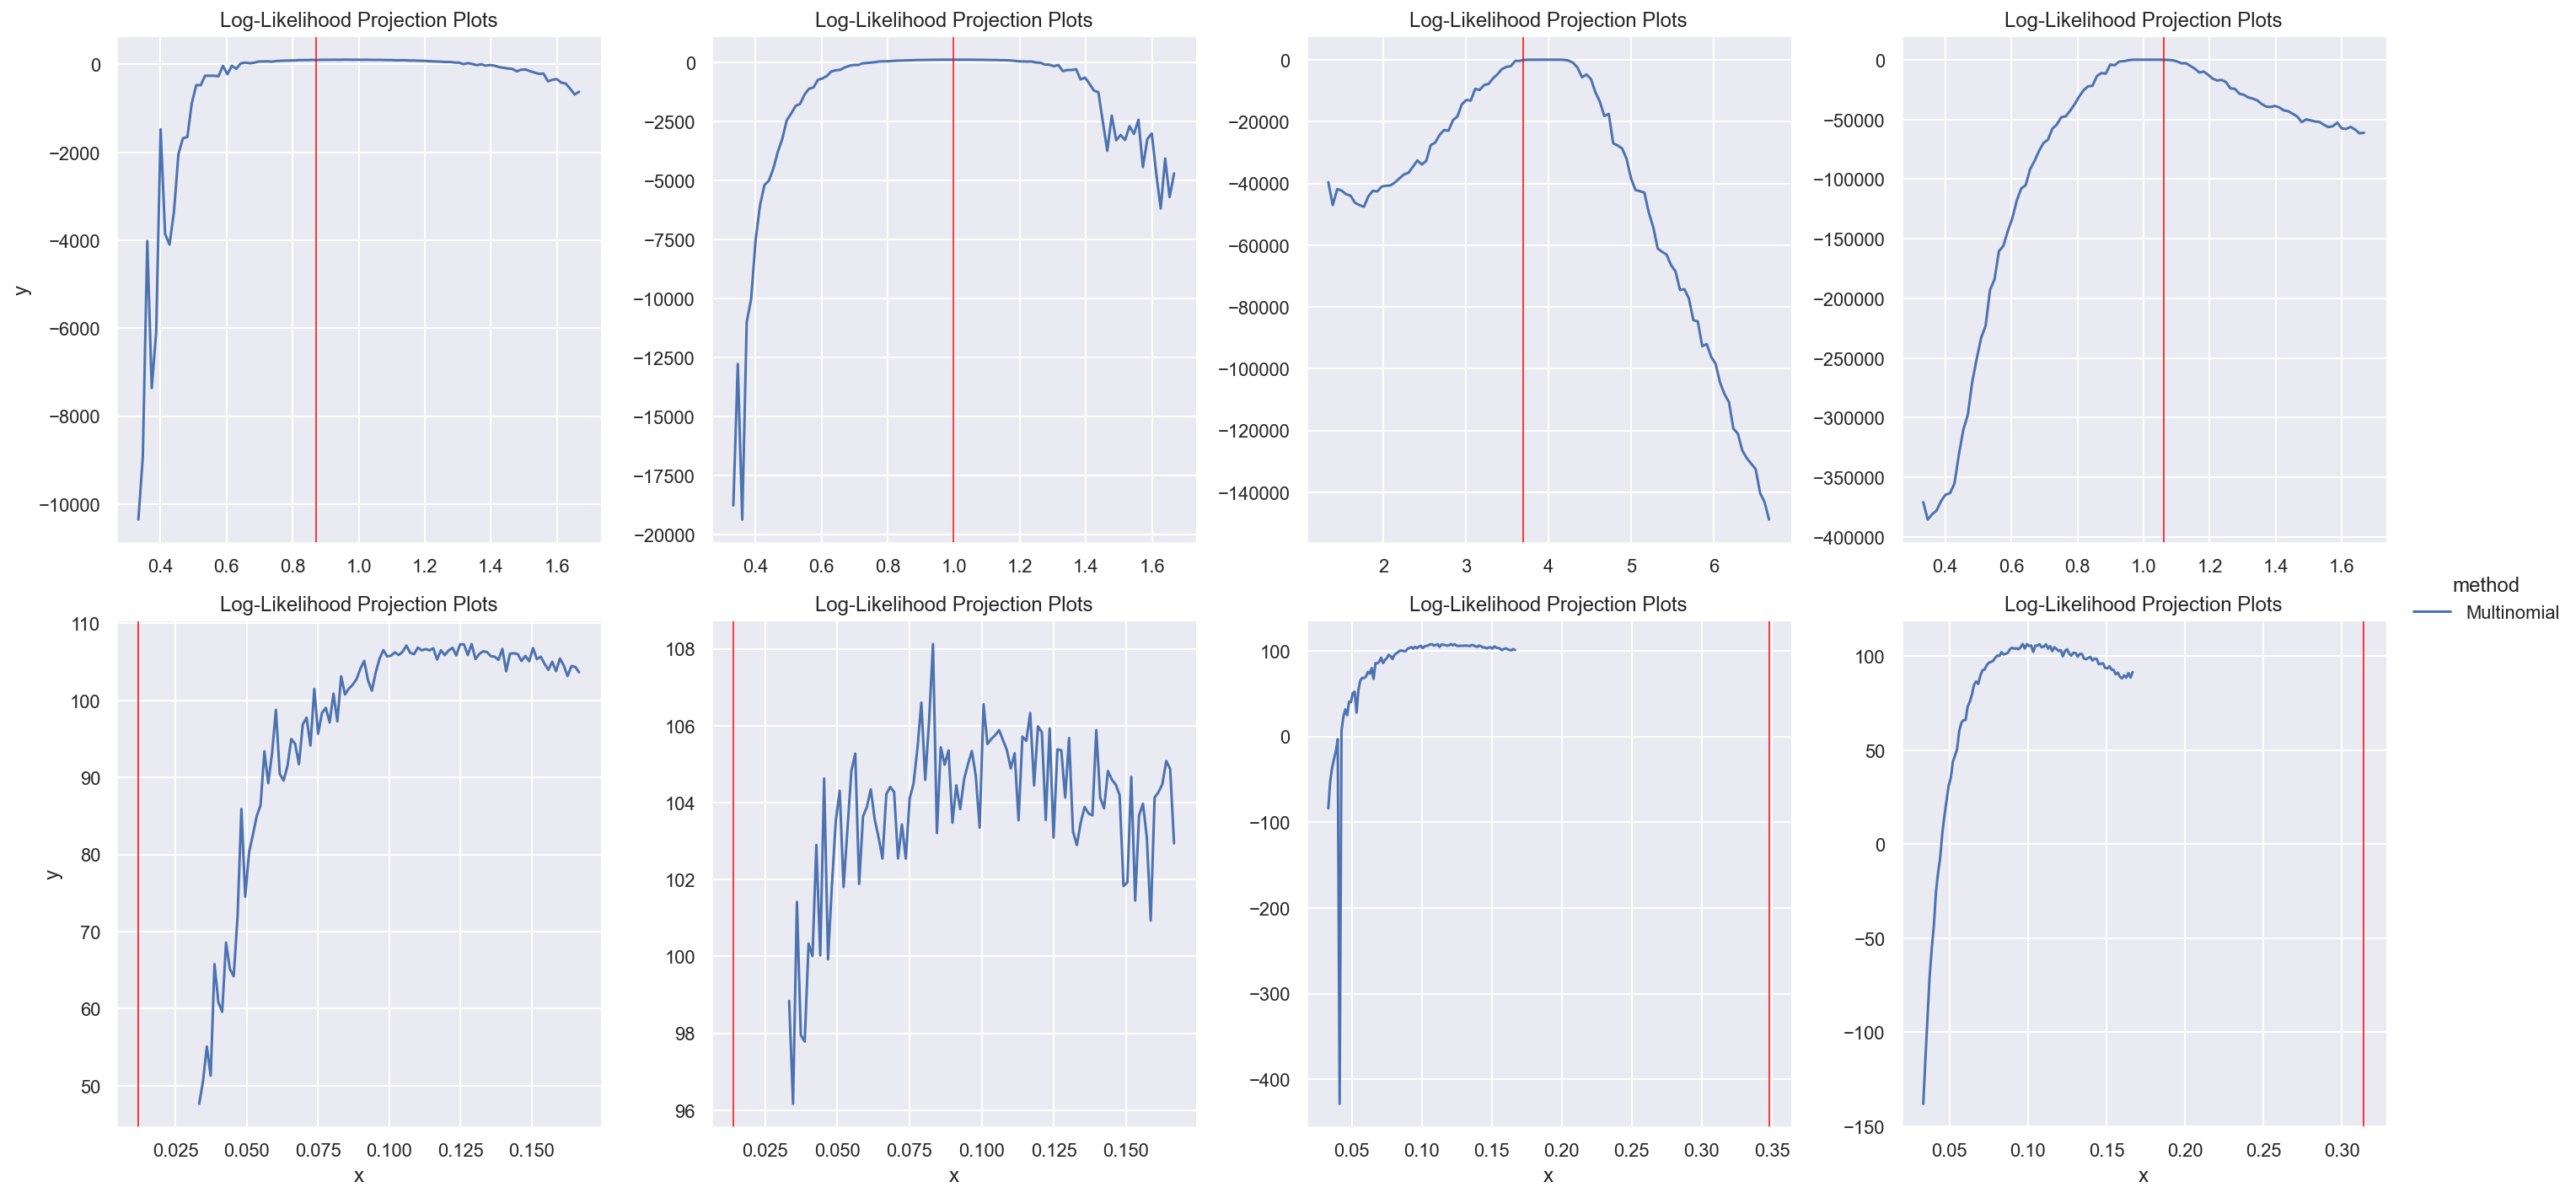

In [89]:
plot_multinom = pf.proj_data(fun = lambda x: lotvol_pf_loglik(x),
                           theta = theta, 
                           theta_lims = theta_lims, 
                           theta_names = theta_names)

plot_multinom["method"] = "Multinomial"

grid = sns.relplot(
    data=plot_multinom, 
    kind="line",
    hue = "method",
    x="x", y="y", 
    col="theta",
    col_wrap=4,
    facet_kws=dict(sharex=False, sharey=False)
).set(title="Log-Likelihood Projection Plots");

for ind, _ax in enumerate(grid.axes.flat):
    _ax.axvline(multinom_params[ind], color='red', lw = 0.75);

In [85]:
# check that we have minimized the negative log-lik: Hessian should be positive definite: 
multinom_hessian_fn = jax.jacfwd(jax.jacrev(pf.particle_neg_loglik))
multinom_hess = multinom_hessian_fn(
    multinom_params,
    key,
    n_particles=n_particles,
    y_meas=y_meas,
    model=lotvol_model)
print("Is positive definite?: ", jnp.all(jnp.linalg.eigvals(multinom_hess) >= 0))

Is positive definite?:  False


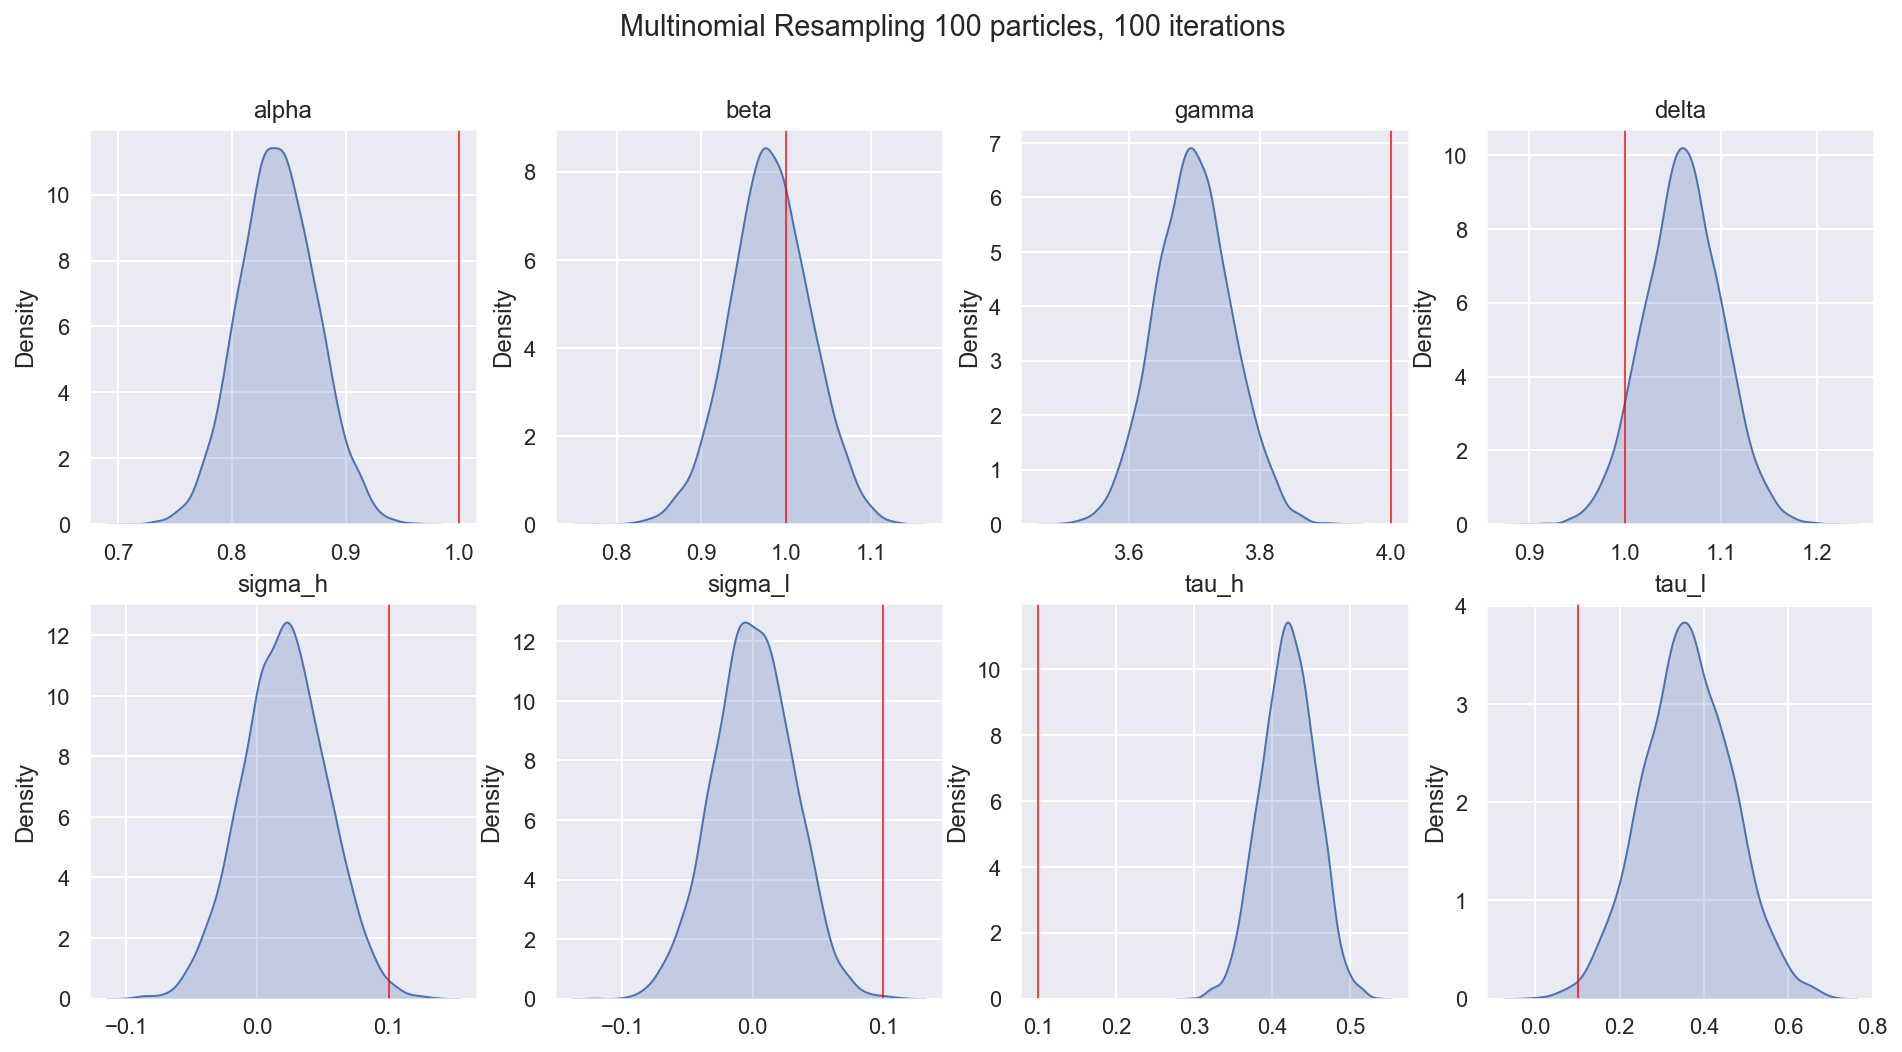

In [86]:
multinom_var = jnp.linalg.inv(multinom_hess) + np.diag([1e-3]*len(multinom_params))
mn_mle_samples = random.multivariate_normal(
    key=key, 
    mean=multinom_params, 
    cov=multinom_var, 
    shape=(5_000, ))

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
fig.suptitle("Multinomial Resampling {} particles, {} iterations".format(n_particles, n_iter)) 
for ind, _ax in enumerate(ax.flatten()):
    sns.kdeplot(mn_mle_samples[:, ind], ax = _ax, shade = True).set_title(theta_names[ind])
    _ax.axvline(theta[ind], color='red', lw = 0.75)
plt.show();